# [FastSurfer](https://github.com/nikhil153/FastSurfer) model performance analysis 

## Datasets
- ukb pilot [cohort](https://github.com/neurodatascience/watts_up_compute/blob/impact_tracker/subject_lists/ukb_pilot_subjects.csv)

## Current analysis:
- model pruning 

## Perfomance measures
- dice for DKT volumetric segmentation

In [1]:
import nibabel as nib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from dask import compute, delayed
import dask.multiprocessing

sys.path.append('../../')
sys.path.append('../')
from lib.fastsurfer_utils import *


### Paths

In [2]:
project_dir = '../'
exp_dir = '{}/FastSurfer_experiments/'.format(project_dir)
results_dir = '{}results/prunning/ukb/'.format(exp_dir)

### Rough work (sample file converstion)
### Needed to visualize in itksnap

In [3]:
# mgz_file = "/home/nikhil/Downloads/TaskRawWorkdir-FreeSurferReconAll-1807617-1/sub-2017717/mri/aparc.DKTatlas+aseg.mgz" #"/home/nikhil/Downloads/orig.mgz"   #aparc.DKTatlas+aseg.deep.mgz"
# mgz_file = "/home/nikhil/Desktop/orig.mgz" 
# convert_mgz_to_nifti(mgz_file)

## Sample single subject case

In [5]:
FreeSurfer_label = "/home/nikhil/Downloads/TaskRawWorkdir-FreeSurferReconAll-1807617-1/sub-2017717/mri/aparc.DKTatlas+aseg.mgz"

FastSurfer_label_dict = {'orig': '/home/nikhil/Downloads/aparc.DKTatlas+aseg.deep.mgz', 
                     'prune_50':'/home/nikhil/Downloads/aparc.DKTatlas+aseg.deep_prune_50.mgz'}

fs_seg = nib.load(FreeSurfer_label).get_fdata()
unique_labels = set(fs_seg.ravel())
print('{} unique labels found'.format(len(unique_labels)))

dice_df_concat = pd.DataFrame()

for prune, FastSurfer_label in FastSurfer_label_dict.items(): 
    print('Prune: {}'.format(prune))
    deep_seg = nib.load(FastSurfer_label).get_fdata()
    dice_df = get_multi_label_dice(unique_labels, fs_seg, deep_seg)
    dice_df['pruning'] = prune
    dice_df_concat = dice_df_concat.append(dice_df)


104 unique labels found
Prune: orig
Prune: prune_50


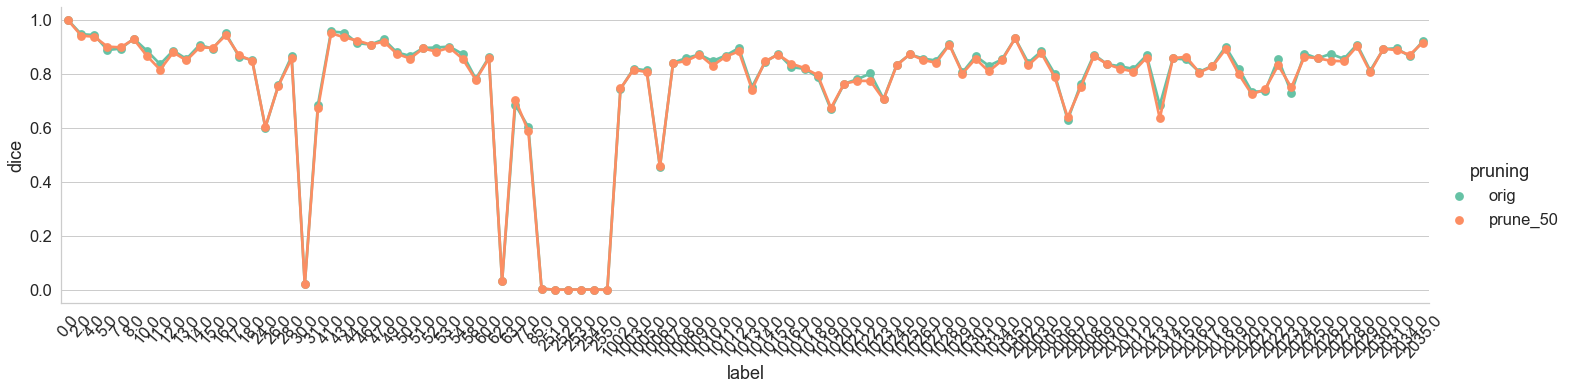

In [7]:
plot_df = dice_df_concat.copy()
plot_df = plot_df.sort_values(['label'])
plot_df['label'] = plot_df['label'].astype(str)
sns.set(font_scale = 1.5)
with sns.axes_style("whitegrid"):
    g = sns.catplot(x='label',y='dice', hue='pruning', kind='point', data=plot_df, palette='Set2',height=5, aspect=4, sharex=True, sharey=True)
    g.set_xticklabels(rotation=50)

## Cohort performances

In [9]:
# mni dataset
# FreeSurfer_label_dir = '/home/nikhil/projects/Parkinsons/data/fs60/segmentations/'
# FastSurfer_label_dir = '/home/nikhil/projects/green_comp_neuro/FastSurfer/data/'

# ukb dataset
FreeSurfer_label_dir = '/home/nikhil/projects/green_comp_neuro/output/fs6.0/'
FastSurfer_label_dir = '/home/nikhil/projects/green_comp_neuro/FastSurfer/output/'

ignore_subjects = {'sub-1009760'}

In [11]:
cohort = 'ukb'
prunnings = ['prune_25','prune_50'] #['prune_10','prune_25','prune_50','prune_75','prune_90']
save_perf = False

for prunning in prunnings:
    print('\nStarting with pruning: {}'.format(prunning))
    FreeSurfer_subjects = os.listdir('{}{}'.format(FreeSurfer_label_dir,cohort))
    FastSurfer_subjects = os.listdir('{}{}/{}'.format(FastSurfer_label_dir,cohort, prunning))
    common_subject = list(set(FastSurfer_subjects) & set(FreeSurfer_subjects) - ignore_subjects)

    print('n subjects\nFreeSurfer:{}, FastSurfer:{}, common:{}'.format(len(FreeSurfer_subjects), len(FastSurfer_subjects), len(common_subject)))

    dice_df_concat = pd.DataFrame()
    unique_labels = None
    for s, sub in enumerate(common_subject):
        print('Subject id: {},{}'.format(s,sub))
        FreeSurfer_label = FreeSurfer_label_dir + '{}/{}/aparc.DKTatlas+aseg.mgz'.format(cohort,sub)
        FastSurfer_label = FastSurfer_label_dir + '{}/{}/{}/aparc.DKTatlas+aseg.deep.mgz'.format(cohort,prunning,sub)

        try:
            fs_seg = nib.load(FreeSurfer_label).get_fdata()
            deep_seg = nib.load(FastSurfer_label).get_fdata()

            if unique_labels == None:
                unique_labels = set(fs_seg.ravel())
                print('{} unique labels found'.format(len(unique_labels)))

            dice_df = get_multi_label_dice(unique_labels, fs_seg, deep_seg)
            dice_df['prunning'] = prunning
            dice_df['cohort'] = cohort
            dice_df['subject_id'] = sub
            dice_df_concat = dice_df_concat.append(dice_df)

        except:
            continue

    if save_perf:
        dice_csv = results_dir + '{}/dice_perf.csv'.format(prunning)
        dice_df_concat.to_csv(dice_csv)




Starting with pruning: prune_25
n subjects
FreeSurfer:73, FastSurfer:0, common:0
Starting with pruning: prune_50
n subjects
FreeSurfer:73, FastSurfer:0, common:0


In [19]:
dice_df_concat

,label,dice,prunning,cohort,subject_id
0,0.0,0.998714,prune_0,ukb,sub-1000011
1,1025.0,0.905070,prune_0,ukb,sub-1000011
2,1026.0,0.883758,prune_0,ukb,sub-1000011
3,2.0,0.969205,prune_0,ukb,sub-1000011
4,1028.0,0.927627,prune_0,ukb,sub-1000011
...,...,...,...,...,...
102,1019.0,0.811981,prune_0,ukb,sub-1838053
103,1020.0,0.783576,prune_0,ukb,sub-1838053
104,1021.0,0.791441,prune_0,ukb,sub-1838053
105,1022.0,0.860791,prune_0,ukb,sub-1838053


## Load previously saved perf

In [30]:
dice_df_concat = pd.DataFrame()
cohorts = ['ukb'] #['NC,'ET','PD']
prunnings = ['prune_0'] #
for prunning in prunnings:
    for cohort in cohorts:
        dice_csv = results_dir + '{}/dice_perf.csv'.format(prunning)
        dice_df = pd.read_csv(dice_csv)
        dice_df['prunning'] = prunning
        dice_df_concat = dice_df_concat.append(dice_df)

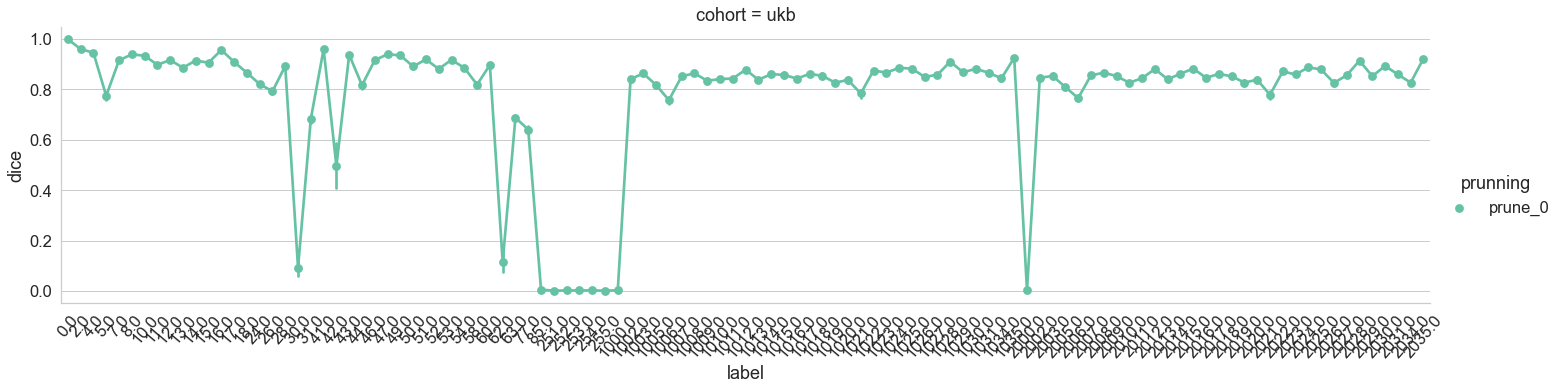

In [31]:
plot_df = dice_df_concat.copy()
plot_df = plot_df.sort_values(['label'])
plot_df['label'] = plot_df['label'].astype(str)
hue_order = prunnings
sns.set(font_scale = 1.5)
with sns.axes_style("whitegrid"):
    g = sns.catplot(x='label',y='dice', hue='prunning', col='cohort', col_wrap=1, kind='point', hue_order=hue_order ,data=plot_df, palette='Set2',height=5, aspect=4, sharex=True, sharey=True)
        


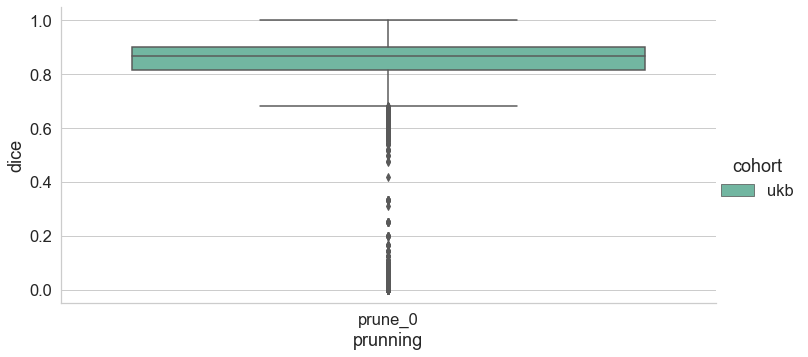

In [22]:
plot_df = dice_df_concat.copy()
plot_df = plot_df.sort_values(['label'])
plot_df['label'] = plot_df['label'].astype(str)

cohorts = ['ukb']
sns.set(font_scale = 1.5)
hue_order = cohorts
x_order = prunnings
with sns.axes_style("whitegrid"):
    g = sns.catplot(x='prunning',y='dice', hue='cohort', kind='box', data=plot_df, palette='Set2', order=x_order, hue_order=hue_order, height=5, aspect=2, sharex=True, sharey=True)
    


## Filter performance of stable ROIs

In [27]:
dice_thresh = 0.5
label_df = dice_df_concat[dice_df_concat['prunning']=='prune_0'].groupby(['label']).median().reset_index()
stable_ROIs = label_df[label_df['dice']>dice_thesh]['label'].unique()
print('theshold: {}, number of stable ROIs: {}'.format(dice_thresh, len(stable_ROIs)))

theshold: 0.5, number of stable ROIs: 96


(81205, 6)
(65479, 6)


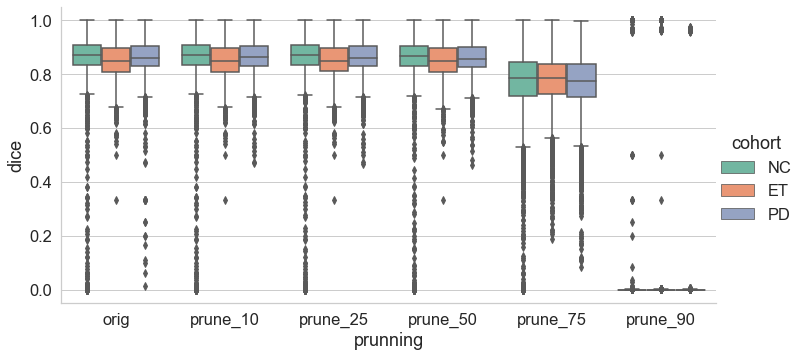

In [34]:
plot_df = dice_df_concat.copy()
print(plot_df.shape)
plot_df = plot_df[plot_df['label'].isin(stable_ROIs)]
print(plot_df.shape)
plot_df = plot_df.sort_values(['label'])
plot_df['label'] = plot_df['label'].astype(str)

sns.set(font_scale = 1.5)
hue_order = cohorts
x_order = prunnings
with sns.axes_style("whitegrid"):
    g = sns.catplot(x='prunning',y='dice', hue='cohort', kind='box', data=plot_df, palette='Set2', order=x_order, hue_order=hue_order, height=5, aspect=2, sharex=True, sharey=True)